In [16]:
# ==============================================================================
# 1. INSTALAÇÃO E IMPORTAÇÕES
# ==============================================================================
!pip install facenet-pytorch gdcm pydicom gdown

import os
import zipfile
import gdown
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from facenet_pytorch import MTCNN, InceptionResnetV1

In [17]:
# ==============================================================================
# 2. CONFIGURAÇÕES GERAIS E DISPOSITIVO
# ==============================================================================
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Dispositivo de processamento: {DEVICE}")

# Configuração dos caminhos dos arquivos
FILES_CONFIG = {
    "dataset.zip": "1Mrx0OKnBFteOw1q8IZy-n8x9q8cxZwhT",
    "marcelinho_clean.jpg": "1EgvzTNEWTXvegURlmJAt8OXOtrKAlQEb",
    "marcelinho_mask.jpg": "1RcLasSJj-XMke5Fj33adiaHWbbl-9ihW"
}

DATASET_FOLDER = "./lfw_funneled"


Dispositivo de processamento: cuda:0


In [18]:
# ==============================================================================
# 3. DEFINIÇÃO DE MODELOS E FUNÇÕES AUXILIARES
# ==============================================================================

def load_models(device):
    """
    Carrega o modelo InceptionResnetV1 pré-treinado e os detectores MTCNN.
    Retorna:
        resnet: Modelo de extração de características.
        mtcnn_padrao: Detector facial com limiares padrão (alta precisão).
        mtcnn_sensivel: Detector facial com limiares relaxados (para máscaras).
    """
    # Modelo de Metric Learning (pré-treinado no vggface2)
    resnet = InceptionResnetV1(pretrained='vggface2').eval().to(device)

    # Detector Padrão
    mtcnn_padrao = MTCNN(
        image_size=160, margin=0,
        min_face_size=20,
        thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
        device=device
    )

    # Detector Sensível (thresholds reduzidos para detectar rostos com máscara)
    mtcnn_sensivel = MTCNN(
        image_size=160, margin=0,
        thresholds=[0.4, 0.5, 0.5],
        factor=0.709, post_process=True,
        device=device
    )

    return resnet, mtcnn_padrao, mtcnn_sensivel

def get_embedding_robusto(image_path, resnet, mtcnn_padrao, mtcnn_sensivel, device):
    """
    Gera o vetor descritor (embedding) de uma imagem.
    Tenta detecção padrão primeiro; se falhar, tenta detecção sensível (útil para máscaras).
    """
    try:
        img = Image.open(image_path)
        if img.mode != 'RGB':
            img = img.convert('RGB')

        # Tentativa 1: Detector Padrão
        face_tensor = mtcnn_padrao(img)

        # Tentativa 2: Detector Sensível (se falhou a primeira)
        if face_tensor is None:
            face_tensor = mtcnn_sensivel(img)

        # Se detectou algo, gera o embedding
        if face_tensor is not None:
            face_tensor = face_tensor.unsqueeze(0).to(device)
            with torch.no_grad():
                embedding = resnet(face_tensor)
            # Retorna como array numpy unidimensional
            return embedding.detach().cpu().numpy()[0]

        return None

    except Exception as e:
        print(f"Erro ao processar {image_path}: {e}")
        return None

def download_and_extract_data(files_config, dataset_folder):
    """Baixa os arquivos necessários e descompacta o dataset se ainda não existir."""
    print("Iniciando download dos arquivos...")
    for filename, drive_id in files_config.items():
        if not os.path.exists(filename):
            url = f'https://drive.google.com/uc?id={drive_id}'
            gdown.download(url, filename, quiet=False)

    if not os.path.exists(dataset_folder):
        print("Descompactando Dataset...")
        with zipfile.ZipFile("dataset.zip", 'r') as zip_ref:
            zip_ref.extractall(".")
        print("Dataset pronto.")
    else:
        print("Dataset já descompactado.")


In [19]:
# ==============================================================================
# 4. EXECUÇÃO PRINCIPAL (AJUSTADO PARA A ESTRUTURA "post-processed")
# ==============================================================================

# 4.1 Preparação dos Dados
download_and_extract_data(FILES_CONFIG, DATASET_FOLDER)

# --- DEFINIÇÃO CORRETA DA PASTA ---
# Baseado na sua imagem, a pasta raiz das imagens é "post-processed"
DATASET_FOLDER = "./post-processed"

if not os.path.exists(DATASET_FOLDER):
    print(f"ALERTA: A pasta '{DATASET_FOLDER}' não foi encontrada.")
    print("Verifique se o arquivo dataset.zip foi descompactado corretamente.")
    # Tenta achar caso tenha outro nome
    dirs = [d for d in os.listdir('.') if os.path.isdir(d) and not d.startswith('.')]
    print(f"Pastas disponíveis na raiz: {dirs}")
else:
    print(f"Dataset localizado em: '{DATASET_FOLDER}'")

# 4.2 Inicialização dos Modelos
resnet, mtcnn_padrao, mtcnn_sensivel = load_models(DEVICE)

# 4.3 Criação do Banco de Dados de Embeddings COMPLETO
database = {}
print("Iniciando processamento do banco de dados...")

total_processado = 0

# Percorre a estrutura: post-processed -> Nome_Pessoa -> Arquivos
for root, dirs, files in os.walk(DATASET_FOLDER):
    # Ignora pastas ocultas
    dirs[:] = [d for d in dirs if not d.startswith('.')]

    # Filtra apenas imagens jpg/jpeg
    imgs = [f for f in files if f.lower().endswith(('.jpg', '.jpeg'))]

    if len(imgs) > 0:
        # Pega a primeira imagem válida da pasta da pessoa
        path = os.path.join(root, imgs[0])

        # O nome da pessoa é o nome da pasta onde a imagem está (ex: AJ_Lamas)
        name = os.path.basename(root)

        # Evita processar a própria pasta raiz se houver imagens soltas lá
        if name == "post-processed":
            continue

        # Gera o embedding
        emb = get_embedding_robusto(path, resnet, mtcnn_padrao, mtcnn_sensivel, DEVICE)

        if emb is not None:
            database[name] = emb
            total_processado += 1

            # Feedback visual a cada 500 processados
            if total_processado % 500 == 0:
                print(f"Processados: {total_processado} pessoas...")

print("-" * 30)
print(f"Concluido. Banco carregado com {len(database)} pessoas.")
print("-" * 30)

# 4.4 Inserir Pessoa Alvo (Sem Mascara) no Banco
# Verifica se o banco não está vazio antes de prosseguir
if len(database) > 0:
    print("Cadastrando Marcelinho (Sem Mascara)...")
    emb_marcelinho = get_embedding_robusto(
        "marcelinho_clean.jpg", resnet, mtcnn_padrao, mtcnn_sensivel, DEVICE
    )

    if emb_marcelinho is not None:
        database["Marcelinho"] = emb_marcelinho
        print("Marcelinho cadastrado com sucesso.")
    else:
        print("ALERTA: Nao foi possivel detectar o rosto na foto 'marcelinho_clean.jpg'.")
else:
    print("ERRO CRÍTICO: O banco de dados continua vazio. Verifique se as imagens dentro de 'post-processed' são arquivos .jpg válidos.")

Iniciando download dos arquivos...
Descompactando Dataset...
Dataset pronto.
Dataset localizado em: './post-processed'
Iniciando processamento do banco de dados...
Processados: 500 pessoas...
Processados: 1000 pessoas...
Processados: 1500 pessoas...
Processados: 2000 pessoas...
Processados: 2500 pessoas...
------------------------------
Concluido. Banco carregado com 2968 pessoas.
------------------------------
Cadastrando Marcelinho (Sem Mascara)...
Marcelinho cadastrado com sucesso.



Iniciando Reconhecimento Facial (Com Mascara)...


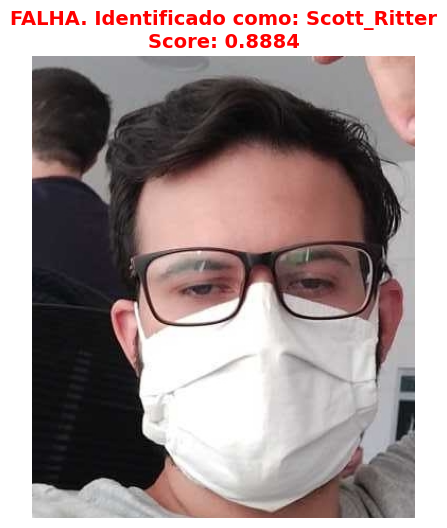

Resultado Final: Scott_Ritter
Metrica (Distancia L2): 0.8884


In [20]:
# ==============================================================================
# 5. INFERÊNCIA E RECONHECIMENTO (COM MÁSCARA)
# ==============================================================================
print("\nIniciando Reconhecimento Facial (Com Mascara)...")

path_inferencia = "marcelinho_mask.jpg"

# Gera o vetor da imagem com mascara
vetor_desconhecido = get_embedding_robusto(
    path_inferencia, resnet, mtcnn_padrao, mtcnn_sensivel, DEVICE
)

if vetor_desconhecido is None:
    print("Erro Critico: O modelo nao conseguiu detectar nenhum rosto na imagem com mascara.")
    print("Tente ajustar os thresholds do mtcnn_sensivel na funcao load_models.")
else:
    min_dist = float('inf')
    identificado = "Desconhecido"

    # Comparar com todos no banco (Distancia Euclidiana L2)
    # Itera sobre o dicionario database criado na etapa anterior
    for nome, vetor_db in database.items():
        # Calculo da distancia euclidiana entre os vetores
        dist = np.linalg.norm(vetor_desconhecido - vetor_db)

        if dist < min_dist:
            min_dist = dist
            identificado = nome

    # -----------------------------------------------------------
    # Exibição dos Resultados
    # -----------------------------------------------------------
    plt.figure(figsize=(8, 6))

    try:
        img_show = Image.open(path_inferencia)
        plt.imshow(img_show)
    except Exception as e:
        print(f"Nao foi possivel exibir a imagem: {e}")

    plt.axis('off')

    # Define a cor do texto baseada no sucesso do teste
    if identificado == "Marcelinho":
        msg = f"SUCESSO! Identificado: {identificado}\nScore (Distancia): {min_dist:.4f}"
        cor_texto = 'green'
    else:
        msg = f"FALHA. Identificado como: {identificado}\nScore: {min_dist:.4f}"
        cor_texto = 'red'

    plt.title(msg, color=cor_texto, fontsize=14, fontweight='bold')
    plt.show()

    print("="*40)
    print(f"Resultado Final: {identificado}")
    print(f"Metrica (Distancia L2): {min_dist:.4f}")
    print("="*40)